In [0]:
#Imports
import string
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, LSTM, Input, Embedding
from keras.models import Model, load_model, save_model
import pickle


In [0]:
#Hyper and Dynamic params
embedding_dim = 50
EPOCHS = 200
BS = 4096 * 2

In [5]:
# Open the database and show the number of lines in it.
with open("republic.txt", mode = "r") as file:
  print(len(file.readlines()))

15802


Data Prepration

    Book/Chapter headings (e.g. “BOOK I.”).
    British English spelling (e.g. “honoured”)
    Lots of punctuation (e.g. “–“, “;–“, “?–“, and more)
    Strange names (e.g. “Polemarchus”).
    Some long monologues that go on for hundreds of lines.
    Some quoted dialog (e.g. ‘…’)



In [6]:
# Load doc into memory.
def load_doc(filename):
  with open(filename, mode = "r") as file:
    text = file.read()
  return text

file_addr = "republic.txt"
doc = load_doc(file_addr)
print(doc[:200])

BOOK I.

I went down yesterday to the Piraeus with Glaucon the son of Ariston,
that I might offer up my prayers to the goddess (Bendis, the Thracian
Artemis.); and also because I wanted to see in what


### Clean Text


* Replace ‘–‘ with a white space so we can split words better.
* Split words based on white space.
* Remove all punctuation from words to reduce the vocabulary size (e.g. ‘What?’ becomes ‘What’).
* Remove all words that are not alphabetic to remove standalone punctuation tokens.
* Normalize all words to lowercase to reduce the vocabulary size.


In [0]:
#Turn a doc into clean tokens
def clean_doc(doc):
      # replace '--' with a space ' '
      doc = doc.replace("--", " ")
      # split into tokens by white space
      tokens = doc.split()
      # remove punctuation from each token
      table = str.maketrans(" ", " ", string.punctuation)
      tokens = [w.translate(table) for w in tokens]
      # remove remaining tokens that are not alphabetic
      tokens = [word for word in tokens if word.isalpha()]
      # make lower case
      tokens = [word.lower() for word in tokens]

      return tokens

In [8]:
#Clean doc
tokens = clean_doc(doc)
print(f"Total tokens:{len(tokens)}")
print(f"Total unique tokens:{len(set(tokens))}")

Total tokens:118684
Total unique tokens:7409


In [9]:
#Organize into sequences of tokens
length = 50 + 1
sequences = []
for i in range(len(tokens) - length): #Compare the output of loops
  seq = tokens[i:i + length]
  line = " ".join(seq)
  sequences.append(line)

print(f"Total sequences{len(sequences)}")

Total sequences118633


In [0]:
# save tokens to file, one dialog per line
def save_doc(tokens, filename):
  with open(filename, mode = "w") as file:
    tokens = "\n".join(tokens)
    file.write(tokens)

In [0]:
# save sequences to file
pure_tokens_addr = "republic_tokens.txt"
save_doc(sequences, pure_tokens_addr)

# Train Language Model

* It uses a distributed representation for words so that different words with similar meanings will have a similar representation.
* It learns the representation at the same time as learning the model.
* It learns to predict the probability for the next word using the context of the last 100 words.

In [0]:
#Load processed Database and turn it into lines
doc = load_doc(pure_tokens_addr)
lines = doc.split("\n")

###Encode Sequences

The word embedding layer expects input sequences to be comprised of integers.

We can map each word in our vocabulary to a unique integer and encode our input sequences. Later, when we make predictions, we can convert the prediction to numbers and look up their associated words in the same mapping.

To do this encoding, we will use the Tokenizer class in the Keras API.

First, the Tokenizer must be trained on the entire training dataset, which means it finds all of the unique words in the data and assigns each a unique integer.

We can then use the fit Tokenizer to encode all of the training sequences, converting each sequence from a list of words to a list of integers.

We can access the mapping of words to integers as a dictionary attribute called word_index on the Tokenizer object

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [14]:
#Vocabulary size
vocab_size = len(tokenizer.word_index) + 1 # what is 1 ?
print(f"Vocab size:{vocab_size}")

Vocab size:7410


In [15]:
#Separate into input and output
sequences = np.array(sequences)

x_train, y_train = sequences[:, :-1], sequences[:, -1]
y_train = to_categorical(y_train, num_classes = vocab_size)
seq_length = x_train.shape[1]
print(f"Seq length:{seq_length}")
print(f"x_train shape:{x_train.shape}")
print(f"y_train shape:{y_train.shape}")

Seq length:50
x_train shape:(118633, 50)
y_train shape:(118633, 7410)


There are two primary situations when you can apply the return_sequences to return the full sequence.


1.   Stacking RNN, the former RNN layer or layers should set return_sequences to True so that the following RNN layer or layers can have the full sequence as input.

2.       We want to generate classification for each time step:


  1.           Such as speech recognition or much simpler form - trigger word detection where we generate a value between 0~1 for each timestep representing whether the trigger word is present.
  2.   OCR(Optical character recognition) sequence modeling with CTC.
 







Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            370500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 128)           91648     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 7410)              955890    
Total params: 1,566,134
Trainable params: 1,566,134
Non-trainable params: 0
___________________________________________

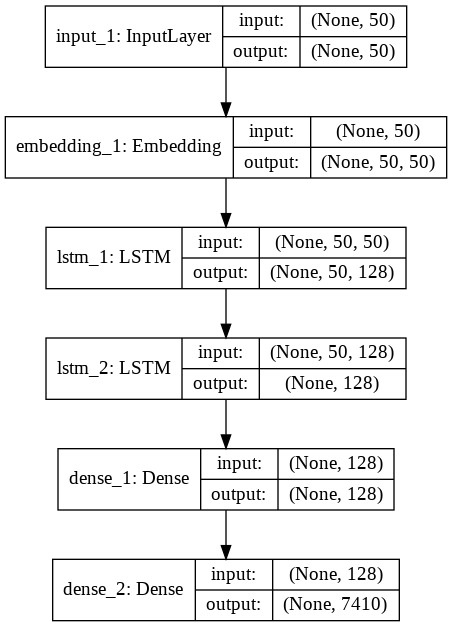

In [16]:
# define model
inputs = Input(shape=(seq_length,))

x = inputs
x = Embedding(input_dim=vocab_size, output_dim = embedding_dim )(x)
x = LSTM(128, return_sequences = True)(x)
x = LSTM(128)(x)
x = Dense(units=128,
          kernel_initializer = "he_normal",
          activation="relu")(x)
outputs = Dense(units = vocab_size, activation = "softmax")(x)

model = Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])
model.summary()
plot_model(model,  to_file="model.png", show_shapes = True)

In [17]:
#Fit
if os.path.exists("model.h5"):
  model = load_model("model.h5")
else:
  model.fit(x_train,
            y_train,
            epochs = EPOCHS, 
            batch_size = BS)
save_model(model, "model.h5")

pickle.dump(tokenizer, open("tokenizer.pkl", mode = "wb"))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200





118633/118633 [==============================] - 12s 105us/step - loss: 8.6678 - acc: 0.0539
Epoch 2/200
118633/118633 [==============================] - 8s 64us/step - loss: 6.4770 - acc: 0.0597
Epoch 3/200
118633/118633 [==============================] - 8s 64us/step - loss: 6.1604 - acc: 0.0597
Epoch 4/200
118633/118633 [==============================] - 8s 64us/step - loss: 6.1231 - acc: 0.0597
Epoch 5/200
118633/118633 [==============================] - 8s 64us/step - loss: 6.1132 - acc: 0.0597
Epoch 6/200
118633/118633 [==============================] - 8s 64us/step - loss: 6.1102 - acc: 0.0597
Epoch 7/200
118633/118633 [==============================] - 8s 64us/step - loss: 6.1092 - acc: 0.0597
Epoch 8/200
118633/118633 [==============================] - 8s 64us/step - loss: 6.1094 - acc: 0.0597
Epoch 9/200
118633/118633 [==============================] - 8s 64us/ste

In [65]:
# Generate test data seed
seed_text = lines[np.random.randint(0, len(lines))]
print( seed_text + "\n" )

indeed few to fight as they are few to rule and at the same time their fondness for money makes them unwilling to pay taxes how discreditable and as we said before under such a constitution the same persons have too many callings they are husbandmen tradesmen warriors all in one



In [0]:
# Predict
def generate_seq(model, tokenizer, seed, n_words):

  result = []
  input_text = seed

  for _ in range(n_words):

    x_test = np.array(tokenizer.texts_to_sequences([input_text]))
    x_test = pad_sequences(x_test, maxlen = seq_length, truncating = "pre")
    predicted = np.argmax(model.predict(x_test)[0])

    outword=""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
          outword = word
          break
    input_text += " " + outword
    result.append(outword)
  return " ".join(result)

In [67]:
# Show the result
result = generate_seq(model, tokenizer, seed_text, 50)
print(seed_text)
print(result)

indeed few to fight as they are few to rule and at the same time their fondness for money makes them unwilling to pay taxes how discreditable and as we said before under such a constitution the same persons have too many callings they are husbandmen tradesmen warriors all in one
who is caught you not you say that the soul of the state and the same and the just is to be the flatterer of the earth to the same and the other and the other and is the reverse of true and the same and the other and is
